<a href="https://colab.research.google.com/github/bell-boy/SeizureSense/blob/main/SeizureSense_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
!git clone https://github.com/bell-boy/SeizureSense.git

fatal: destination path 'SeizureSense' already exists and is not an empty directory.


In [1]:
#!pip install mne
import mne
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch import tensor
mne.set_log_level('ERROR')
import torch
import numpy as np
from torch import nn
import scipy as sp
#!pip install torch_geometric
import torch_geometric
from torch_geometric import utils
from torch_geometric.utils import dense_to_sparse
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
import torchvision
import torchvision.transforms as transforms
#!pip install causal-conv1d>=1.1.0
#!pip install mamba-ssm
import torch
from mamba_ssm import Mamba
#!pip install gnn
import torch.nn as nn
#from SeizureSense.gnn.GraphLearner import GraphLearnerNN
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn.conv import GATv2Conv

/opt/conda/envs/ss/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/opt/conda/envs/ss/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Mamba Blocks


In [5]:
class MambaBlock(nn.Module):
    def __init__(self, dim, d_state=16, d_conv=4, expand=2):
        super(MambaBlock, self).__init__()
        self.mamba = Mamba(
            d_model=dim,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        ).to("cuda")

    def forward(self, x):
        return self.mamba(x)


In [6]:
class StackedMambaModel(nn.Module):
    def __init__(self, num_layers, dim, d_state=16, d_conv=4, expand=2):
        super(StackedMambaModel, self).__init__()
        self.layers = nn.ModuleList([MambaBlock(dim, d_state, d_conv, expand) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [7]:
class EEGMamba(nn.Module):
    def __init__(self, num_channels, num_layers, dim, d_state=16, d_conv=4, expand=2):
        super(EEGMamba, self).__init__()
        self.channel_models = nn.ModuleList([StackedMambaModel(num_layers, dim, d_state, d_conv, expand) for _ in range(num_channels)])

    def forward(self, x):
        batch_size = x.size(0)
        channel_outputs = []

        # Iterate over each channel model and corresponding channel data
        for i in range(x.size(1)):
            channel_data = x[:, i, :, :]  # Extract data for the i-th channel
            model = self.channel_models[i]
            output = model(channel_data)
            averaged_output = torch.mean(output, dim=1, keepdim=True)
            channel_outputs.append(averaged_output)

        # Stack the channel outputs along the correct dimension
        combined_output = torch.stack(channel_outputs, dim=1)
        return combined_output

# Graph Structure learning

In [8]:
class GraphLearnerNN(nn.Module):
    def __init__(self, depth, threshold=0.01):
        super().__init__()
        self.depth = depth
        self.threshold= threshold
        self.Q = nn.Linear(depth,depth, bias=False)
        self.K = nn.Linear(depth,depth, bias=False)

    def forward(self,tensor):
        queries = self.Q(tensor)
        keys = torch.transpose(self.K(tensor), -1,-2)
        # Batched matrix multiplication, results in shape (batch, num_nodes, num_nodes)
        adj = torch.bmm(queries,keys) / np.sqrt(self.depth)

        # return the softmax of the learned adjacency matrix
        adj = torch.softmax(adj,dim=-1)

        # Average the adj matrix with the transpose so that the graph will be bidirectional
        # e.g the connection from [1,2] should be the same as [2,1]
        adj = (adj + adj.transpose(-1,-2))/2

        # Set values below specified threshold to 0
        adj[adj<=self.threshold] = 0

        edge_indexes, edge_weights = dense_to_sparse(adj)

        return edge_indexes, edge_weights

# GNN

In [9]:
class GraphAttentionNetwork(nn.Module):
    def __init__(self, kernel_size = 2):
        super().__init__()
        self.gsl = GraphLearnerNN(1,threshold = 0.04)

        self.layer1 = GATv2Conv(1, 1)

        self.layer2 = GATv2Conv(1, 1)

        self.pooling = nn.AvgPool2d(kernel_size=kernel_size)

        self.activation = torch.nn.LeakyReLU()



    def forward(self, x):

        edge_idx, edge_weights = self.gsl(x)

        edge_idx = edge_idx.to(int).to(device)

        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2]))
        x = self.layer1(x, edge_idx)

        x = self.activation(x)

        x = self.layer2(x, edge_idx)
        x = self.activation(x)

        x = x.unsqueeze(0).unsqueeze(0)
        #x = self.pooling(x)

        linear = nn.Linear(x.shape[-1] * x.shape[-2], 2).to(x.device)
        x = linear(torch.flatten(x))
        return x
        x = linear(torch.flatten(x))
        return x

# Seizuresense Architecture


In [44]:
from chbmit.chbmit import FilteredCMP
from mlutils import train
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
class WrapperDataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.data = FilteredCMP(tok_len=60, ctx_len=1, sop=3600, sph=0, path="../physionet.org/files/chbmit/1.0.0/chb01/", use_tok_dim=True)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx][0].reshape((23, -1, 1)), self.data[idx][1]

In [16]:
data = WrapperDataset()

100%|██████████| 2732/2732 [02:45<00:00, 16.56it/s]


In [51]:
class SeizureSense(nn.Module):
    def __init__(self, num_channels, num_layers, dim, d_state=16, d_conv=4, expand=2, kernel_size=2):
        super(SeizureSense, self).__init__()
        self.mamba_model = EEGMamba(num_channels, num_layers, dim, d_state, d_conv, expand)
        self.gnn_model = GraphAttentionNetwork(kernel_size)

    def forward(self, x):
        #print(x.shape)
        x = self.mamba_model(x)
        x = x.squeeze(2)  # making it (batch_size, num_channels, dim)
        #print(x.shape)
        x = self.gnn_model(x)
        return x.unsqueeze(0)

In [38]:
batch_size = 1
learning_rate = 1e-4

training_data, val_data, test_data = torch.utils.data.random_split(data, [0.8, 0.1, 0.1])
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,)

In [52]:
num_channels = 23
sequence_length = 15360
dim = 1
torch.cuda.empty_cache()
model = SeizureSense(num_channels, num_layers=4, dim=dim, d_state=16, d_conv=4, expand=2).to("cuda")
optim = torch.optim.Adam(model.parameters(),)
loss_fn = torch.nn.CrossEntropyLoss(torch.Tensor([1.16, 7.23]).to(device))

In [54]:
d, l = next(iter(train_dataloader))
d = d.to(device)
model(d)

tensor([[-0.0191,  0.1220]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

100%|██████████| 10/10 [1:31:18<00:00, 547.90s/it]


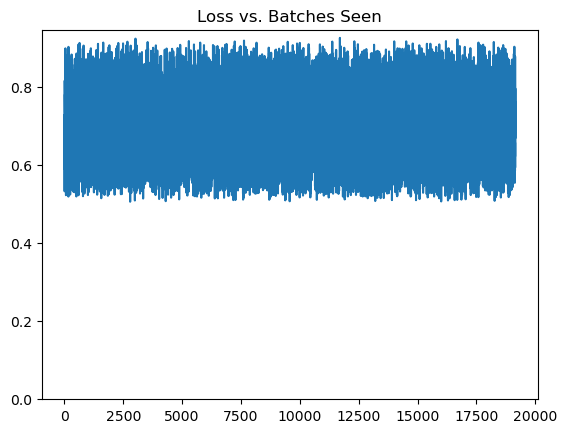

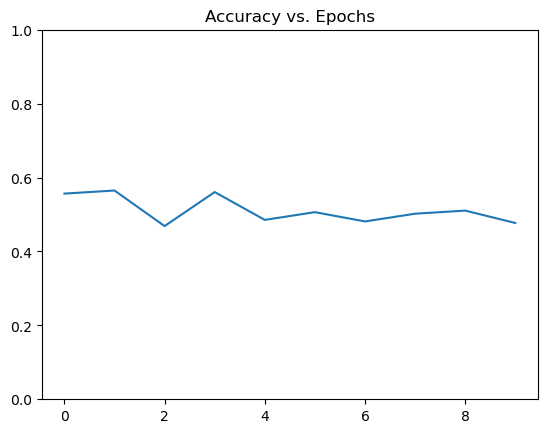

In [55]:
epochs=10
losses = []
accuracy = []
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_classifcation(model, train_dataloader, optim, loss_fn=loss_fn, device=device))
  TP, TN, FP, FN = train.validate_binary_softmax(model, val_dataloader, device=device)
  accuracy.append((TP + TN) / (TP + FP + TN + FN))

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Accuracy vs. Epochs")
plt.plot(accuracy)
plt.ylim((0, 1))
plt.show()

In [42]:
d, l = next(iter(train_dataloader))
d = d.to(device)
model(d).shape

torch.Size([2])